In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import seaborn as sns

# We begin by creating importing the raw data for each recipe, as well as a collection of interactions for each user

In [3]:
recipes_url = 'https://raw.githubusercontent.com/ReginaldLeigh/googleCollab/main/RAW_recipes-short.csv'
df_recipes = pd.read_csv(recipes_url, usecols=['id', 'name'], delimiter=',')[['id', 'name']]
df_recipes.rename(columns={'id': 'recipe_id'}, inplace=True)

In [135]:
df_recipes.head()

,recipe_id,name
0,137739,arriba baked winter squash mexican style
1,31490,a bit different breakfast pizza
2,112140,all in the kitchen chili
3,59389,alouette potatoes
4,44061,amish tomato ketchup for canning


In [137]:
users_url = 'https://raw.githubusercontent.com/ReginaldLeigh/googleCollab/main/RAW_interactions-short.csv'
df_users = pd.read_csv(users_url, usecols=['user_id', 'recipe_id', 'rating'], delimiter=',')
df_users.head()

,user_id,recipe_id,rating
0,38094,40893,4
1,1293707,40893,5
2,8937,44394,4
3,126440,85009,5
4,57222,85009,5


# Next, we will combine these datasets and match each recipe to the rating given by the user

In [138]:
df_interactions = pd.merge(df_users, df_recipes, on='recipe_id')
df_interactions.head()

,user_id,recipe_id,rating,name
0,126440,85009,5,baked potato toppings
1,57222,85009,5,baked potato toppings
2,135017,254596,5,apple apricot pork chops crock pot
3,224088,254596,4,apple apricot pork chops crock pot
4,582223,254596,5,apple apricot pork chops crock pot


# Looking at the bar graph below, we can see that the number of 5-star reviews greatly outweighs all of the other ratings in the dataset

In [142]:
rating_counts = df_interactions['rating'].value_counts().reset_index()
rating_counts.sort_values(by=['rating'], ascending=False, inplace=True)


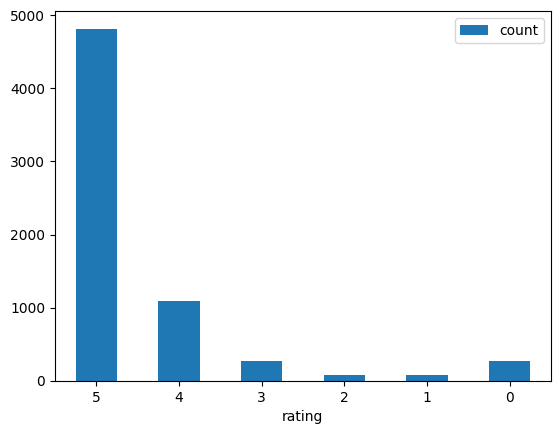

In [8]:
# Rating of 0 is not a mistake, and is valid
bar_chart = rating_counts.plot.bar(x='rating', y='count', rot=0)

# However, the scatter plot below shows that most of these recipes have been reviewed less than 50 times

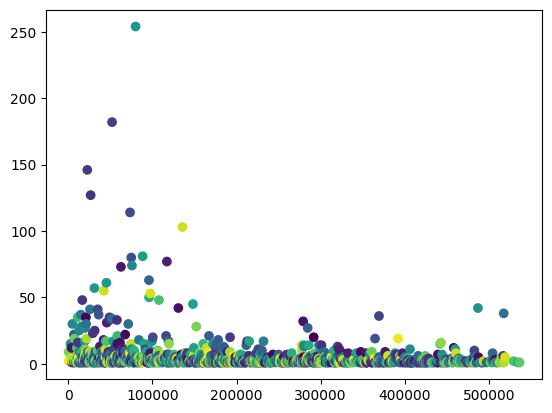

In [9]:
rating_totals = (df_interactions.groupby(by = ['recipe_id'])['rating']).count().reset_index()
rating_totals.rename(columns={'rating': 'totalRatingCount'}, inplace=True)
plt.scatter(rating_totals['recipe_id'], rating_totals['totalRatingCount'], c=np.random.rand(len(rating_totals)))
plt.show()

# By grouping the dataset, the total count of reviews for each recipe can be found

In [139]:
# remove N/As and group data by name
combined_rating = df_interactions.dropna(axis=0, subset=['name'])
rating_count = (combined_rating.groupby(by = ['name'])['rating']).count().reset_index()
rating_count.rename(columns={'rating': 'totalRatingCount'}, inplace=True)
rating_count.head()

,name,totalRatingCount
0,1 dish hot fudge swirl cake,2
1,1 minute no bake chocolatey cereal bites,1
2,10 min japanese simmered tofu hot pot,3
3,10 minute buffalo shrimp with blue cheese dip,17
4,100 chocolate cake,1


In [140]:
# combine ids and total rating count for each user interaction
df_aggData = df_interactions.merge(rating_count, left_on='name', right_on='name', how='left')
df_aggData.head()

,user_id,recipe_id,rating,name,totalRatingCount
0,126440,85009,5,baked potato toppings,2
1,57222,85009,5,baked potato toppings,2
2,135017,254596,5,apple apricot pork chops crock pot,4
3,224088,254596,4,apple apricot pork chops crock pot,4
4,582223,254596,5,apple apricot pork chops crock pot,4


# Looking at the dataset, there are about 6600 reviews that have been left by users

In [141]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(df_aggData['totalRatingCount'].describe())

count   6614.000
mean      41.140
std       60.247
min        1.000
25%        4.000
50%       14.000
75%       48.000
max      254.000
Name: totalRatingCount, dtype: float64


# Using the aggregate information above, a threshold for review count can be set and reviews that have not been rated enough may be removed

In [143]:
# Sets threshold for which to recommend a recipe
popularity_threshold = 4
df_popularRecipes = df_aggData.query('totalRatingCount >= @popularity_threshold')
df_popularRecipes.head()

,user_id,recipe_id,rating,name,totalRatingCount
2,135017,254596,5,apple apricot pork chops crock pot,4
3,224088,254596,4,apple apricot pork chops crock pot,4
4,582223,254596,5,apple apricot pork chops crock pot,4
5,1413963,254596,5,apple apricot pork chops crock pot,4
11,22174,342209,4,banana oatmeal cookies,8


In [14]:
df_popularRecipes.shape

(6343, 5)

In [147]:
rating_counts = df_popularRecipes['rating'].value_counts().reset_index()
rating_counts.sort_values(by=['rating'], ascending=False, inplace=True)
rating_counts.head()

,rating,count
0,5,3965
1,4,804
3,3,175
4,2,69
5,1,61


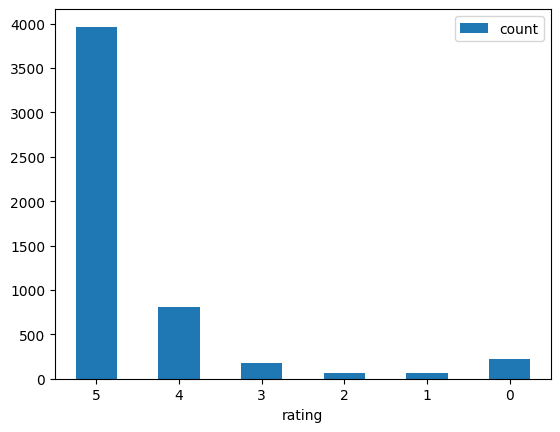

In [148]:
bar_chart = rating_counts.plot.bar(x='rating', y='count', rot=0)

In [149]:
df_popularRecipes.dtypes

user_id              int64
recipe_id            int64
rating               int64
name                object
totalRatingCount     int64
dtype: object

# Next, a pivot table is created using a combination of recipe IDs and user ratings. This will give each recipe a feature set that can be used for comparison against one another

In [17]:
# Creates feature pivot table for each recipe
df_recipeFeatures = df_popularRecipes.pivot_table(index='recipe_id', columns='user_id', values='rating').fillna(0)
df_recipeFeatures.head()

user_id,1535,1962,2586,3288,4291,4439,4470,4500,4796,5060,...,2002257231,2002269393,2002284593,2002291211,2002305435,2002307523,2002312290,2002350586,2002355244,2002361612
recipe_id,,,,,,,,,,,,,,,,,,,,,
355,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,5.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
360,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2155,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2561,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
3496,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [18]:
# Creates sparse matrix
df_recipeMatrix = csr_matrix(df_recipeFeatures.values)

# Using the K-Nearest Neighbor algorithm, we can compare the feature sets of each recipe

In [108]:
# Create K-NearestNeighbor model
knn_model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10)
knn_model.fit(df_recipeMatrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=10)

# The user will enter one of their favorite recipes and a list recommendations will be given based on their selection
A random selection will be used for this demonstration. However the code implemented for the actual model is listed below

In [394]:
# Random selector is used to emulate user interaction
# recipe_id = df_recipes.query('name == "avocado and prawns in wasabi"').iloc[0]['recipe_id']
# for i in range(df_recipeFeatures.shape[0]):
#     if df_recipeFeatures.index[i] == recipe_id:
#         query_index = i

# query_index

In [96]:
# Select random recipe from matrix using index
query_index = np.random.choice(df_recipeFeatures.shape[0])
print(query_index)

939


# Lastly a recommendation will be given based on the cosine distance between the user selection

In [110]:
# Create list of recommendations based off recipes with similar feature set (Collabrative Filtering)
distances, indices = knn_model.kneighbors(df_recipeFeatures.iloc[query_index,:].values.reshape(1,-1), n_neighbors=11)

for i in range(0, len(distances.flatten())):
    if i == 0:                                              # First item is always itself
        id = df_recipeFeatures.index[query_index]
        recipe_name = df_recipes.query('recipe_id == @id').iloc[0]['name']
        print('Top 10 recommendations for {0}:\n'.format(recipe_name))
    else:
        id = df_recipeFeatures.index[indices.flatten()[i]]
        recipe_name = df_recipes.query('recipe_id == @id').iloc[0]['name']
        print('{0}: {1}, with distance of {2}:'.format(i, recipe_name, distances.flatten()[i]))

Top 10 recommendations for banana split cappuccino:

1: baked salmon in foil, with distance of 0.2191311905569696:
2: banana ice cream  weight watchers, with distance of 0.2191311905569696:
3: baked oatmeal, with distance of 0.3753049524455757:
4: banana foster martini, with distance of 0.3753049524455757:
5: baked pina colada oatmeal, with distance of 0.3753049524455757:
6: apple fizz, with distance of 0.3753049524455757:
7: after thanksgiving soup with garlic  spinach  and tomatoes, with distance of 0.4478423696257673:
8: african haze tea latte, with distance of 0.5121951219512195:
9: apple cranberry crumb tart, with distance of 0.5194084699320047:
10: a different grilled cheese sammich, with distance of 0.5491651826662838:


# The scatter plot below shows the relative distance of each recipe in comparison to the user selected item. The lower the distance, the more similar a recipe's feature set is.
The item located at Y = 0.0 is the target recipe

In [150]:
x = []
y = []

for i in range(0, len(distances.flatten())):
    id = df_recipeFeatures.index[indices.flatten()[i]]
    x.append(id)
    y.append(distances.flatten()[i])

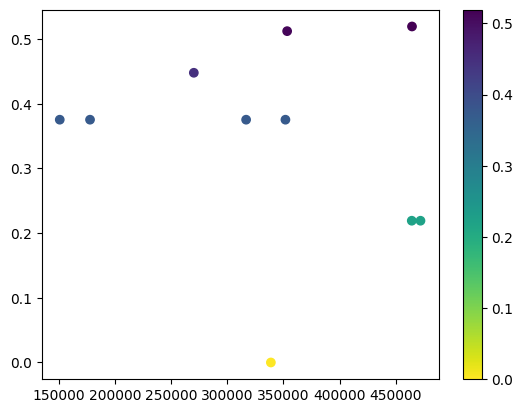

In [133]:
plt.scatter(x, y, c=y, cmap='viridis_r')
plt.colorbar()
plt.show()

# For a working demonstration of this model, please use the following link
NOTE: It may take a few minutes for the website to load

https://recipe-3xix.onrender.com